### Import Libraries

In [40]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
import copy
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler,StandardScaler,LabelEncoder,Normalizer
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import roc_auc_score, roc_curve
import lightgbm as lgb
from sklearn.pipeline import Pipeline
import time
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import warnings
import shap
import random
import joblib
import tensorflow as tf
from tensorflow import keras

In [2]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

## Import functions

In [ ]:
%run census_functions.ipynb

## Data preprocessing

#### Mapping column names from census_income_metadata.txt with header in train and test files

In [3]:
def write_txt():
    f= open("columns.txt","w+")
    f.write('''age,AAGE
class_of_worker,ACLSWKR
industry_code,ADTIND
occupation_code,ADTOCC
#adjusted_gross_income,AGI
education,AHGA
wage_per_hour,AHRSPAY
enrolled_in_edu_inst_last_wk,AHSCOL
marital_status,AMARITL
major_industry_code,AMJIND
major_occupation_code,AMJOCC
race,ARACE
hispanic_Origin,AREORGN
sex,ASEX
member_of_a_labor_union,AUNMEM
reason_for_unemployment,AUNTYPE
full_or_part_time_employment_stat,AWKSTAT
capital_gains,CAPGAIN
capital_losses,CAPLOSS
divdends_from_stocks,DIVVAL
#federal_income_tax_liability,FEDTAX
tax_filer_status,FILESTAT
region_of_previous_residence,GRINREG
state_of_previous_residence,GRINST
detailed_household_and_family_stat,HHDFMX
detailed_household_summary_in_household,HHDREL
instance_weight_ignore,MARSUPWT
migration_code_change_in_msa,MIGMTR1
migration_code_change_in_reg,MIGMTR3
migration_code_move_within_reg,MIGMTR4
live_in_this_house_1_year_ago,MIGSAME
migration_prev_res_in_sunbelt,MIGSUN
num_persons_worked_for_employer,NOEMP
family_members_under_18,PARENT
#total_person_earnings,PEARNVAL
country_of_birth_father,PEFNTVTY
country_of_birth_mother,PEMNTVTY
country_of_birth_self,PENATVTY
citizenship,PRCITSHP
#total_person_income,PTOTVAL
own_business_or_self_employed,SEOTR
#taxable_income_amount,TAXINC
fill_inc_questionnaire_for_veterans_admin,VETQVA
veterans_benefits,VETYN
weeks_worked_in_year,WKSWORK''')
    f.close()

write_txt()

In [4]:
# read-in column file
with open("columns.txt", "r") as file:
    # for each line: strip "\n" off & split into two elements at ","
    col_dict = {i : l.strip("\n").split(',') 
                    for i, l in enumerate(
                            # ignore lines starting with "#"
                            [l for l in file if not l.startswith('#')]
                        ) 
               }
col_dict[len(col_dict)] = ['year','?']

In [5]:
train_file = 'census_income_learn.csv'
test_file = 'census_income_test.csv'

In [6]:
df_train = get_data(train_file)
df_test_a = get_data(test_file)

In [7]:
print('Train data contains',df_train.shape[0],'rows and',df_train.shape[1],'columns')
print('Test data contains',df_test_a.shape[0],'rows and',df_test_a.shape[1],'columns')

Train data contains 199523 rows and 41 columns
Test data contains 99762 rows and 41 columns


In [129]:
train_prop = round(len(df_train)*100/(len(df_test_a)+len(df_train)))
test_prop = round((len(df_test_a)*100/(len(df_test_a)+len(df_train))))
print('Train : Test ratio is',train_prop,':',test_prop)

Train : Test ratio is 67 : 33


In [130]:
# Check data head
df_train.head()

,age,class_of_worker,industry_code,occupation_code,education,wage_per_hour,enrolled_in_edu_inst_last_wk,marital_status,major_industry_code,major_occupation_code,race,hispanic_Origin,sex,member_of_a_labor_union,reason_for_unemployment,full_or_part_time_employment_stat,capital_gains,capital_losses,divdends_from_stocks,tax_filer_status,region_of_previous_residence,state_of_previous_residence,detailed_household_and_family_stat,detailed_household_summary_in_household,migration_code_change_in_msa,migration_code_change_in_reg,migration_code_move_within_reg,live_in_this_house_1_year_ago,migration_prev_res_in_sunbelt,num_persons_worked_for_employer,family_members_under_18,country_of_birth_father,country_of_birth_mother,country_of_birth_self,citizenship,own_business_or_self_employed,fill_inc_questionnaire_for_veterans_admin,veterans_benefits,weeks_worked_in_year,year,41
0,73,Not in universe,0,0,High school graduate,0,Not in universe,Widowed,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0,95,- 50000.
1,58,Self-employed-not incorporated,4,34,Some college but no degree,0,Not in universe,Divorced,Construction,Precision production craft & repair,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1,Not in universe,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52,94,- 50000.
2,18,Not in universe,0,0,10th grade,0,High school,Never married,Not in universe or children,Not in universe,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force,0,0,0,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,0,Not in universe,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0,95,- 50000.
3,9,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.
4,10,Not in universe,0,0,Children,0,Not in universe,Never married,Not in universe or children,Not in universe,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces,0,0,0,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0,Both parents present,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0,94,- 50000.


### Convert Target variable to binary

In [8]:
df_train['target'] = df_train[41].apply(lambda x: 1 if x == ' 50000+.' else 0)
df_test_a['target'] = df_test_a[41].apply(lambda x: 1 if x == ' 50000+.' else 0)

del df_train[41]
del df_test_a[41]

target_col = 'target'

### Check for duplicates in train and test

In [132]:
print('Duplicates in train:',df_train.duplicated().sum(),'('+str(round(df_train.duplicated().sum()*100/len(df_train),1))+'%)')
print('Duplicates in test:',df_test_a.duplicated().sum(),'('+str(round(df_test_a.duplicated().sum()*100/len(df_test_a),1))+'%)')

print('\nThese duplicates will create a bias in the modelling i.e. Model will try to capture more pattern from the same data points')
print('Hence, it makes sense to remove these duplicate data points from train. No need to remove from test, as the model is not trained on that')

Duplicates in train: 46627 (23.4%)
Duplicates in test: 20898 (20.9%)

These duplicates will create a bias in the modelling i.e. Model will try to capture more pattern from the same data points
Hence, it makes sense to remove these duplicate data points from train. No need to remove from test, as the model is not trained on that


### Drop duplicates from Train data

In [9]:
df_train_a = df_train.drop_duplicates()
# df_test_a = df_test.drop_duplicates()

In [11]:
# Compute intersection of both datasets
intersected_df = pd.merge(df_train_a,df_test_a,how='inner')
N_common = len(intersected_df)
N_train = len(df_train_a)
N_test = len(df_test_a)

print(f'For the train dataset, {N_common/N_train*100:.1f}% ({N_common}) of its entries are found also in the test dataset.')
print(f'For the test dataset,  {N_common/N_test*100:.1f}% ({N_common}) of its entries are found also in the train dataset.')

print('\nConclusion:')
print('\nEven though there are same rows in train and test, there is no need to remove common data points from either of the sets')
print('Since this is a real-world data, there will be individuals with same characteristics and income level in train and test')
#perform outer join
# outer = df_train.merge(df_test, how='outer', indicator=True)

# print(len(outer))
#perform anti-join
# df_train_a = outer[(outer._merge=='left_only')].drop('_merge', axis=1)
# df_test_a = outer[(outer._merge=='right_only')].drop('_merge', axis=1)
# print(len(df_train_a)),print(len(df_test_a))

del intersected_df

For the train dataset, 17.5% (26754) of its entries are found also in the test dataset.
For the test dataset,  26.8% (26754) of its entries are found also in the train dataset.

Conclusion:

Even though there are same rows in train and test, there is no need to remove common data points from either of the sets
Since this is a real-world data, there will be individuals with same characteristics and income level in train and test


In [135]:
### Checkpointing data
# df_train_a.to_csv('cpy/df_train_a.csv',index=False)
# df_test_a.to_csv('cpy/df_test_a.csv',index=False)
# df_train_a = pd.read_csv('cpy/df_train_a.csv')
# df_test_a = pd.read_csv('cpy/df_test_a.csv')

In [112]:
df_train_a = check_NAs(df_train_a,'train set')
df_test_a = check_NAs(df_test_a,'test set')

print('\nColumns where zeros are expected: (ignoring target)')
print(' -> capital_losses, capital_gains, divdends_from_stocks, wage_per_hour, own_business_or_self_employed, industry_code')
print(' -> occupation_code,  num_persons_worked_for_employer (assumption: if the person is unemployed), weeks_worked_in_year, veterans_benefits')

print('\nColumn where zeros are not expected:')
print(' -> age (assumption: could be less than 1 year old)')


No NAs present in the columns of  train set

No empty values present in the columns of  train set

0 values present in the columns of  train set :
                               column      %
14            education_group_profess  98.00
24            worker_class_self_incrp  97.87
20            capital_losses_bucket_1  97.45
6   num_persons_worked_for_employer_5  96.06
33                 weeks_bucket_27_39  95.92
13            education_group_masters  95.77
19             capital_gains_bucket_1  95.18
3   num_persons_worked_for_employer_2  93.43
31                      wage_bucket_1  92.61
34                 weeks_bucket_40_51  92.32
18             married_or_not_sep_wid  91.95
0                              target  91.91
16            married_or_not_divorced  91.82
4   num_persons_worked_for_employer_3  91.25
5   num_persons_worked_for_employer_4  90.63
32                  weeks_bucket_1_26  90.12
12          education_group_bachelors  87.32
21      divdends_from_stocks_bucket_1  86.

### Checking for anomalies in the data
##### Since this dataset is old, assuming older laws as follows:
##### Individual younger than 13 years cannot be:
##### -> a tax filer or working
##### Individual younger than 16 years cannot be (considering 15, if number of months counted): 
##### -> married

In [11]:
tr_anomaly_workers,tr_anomaly_married = anomalies(df_train_a)
te_anomaly_workers,te_anomaly_married = anomalies(df_test_a)

##### Younger than 13 years and working -> in train data

In [12]:
tr_anomaly_workers

,age,wage_per_hour,tax_filer_status,num_persons_worked_for_employer,weeks_worked_in_year,target
9073,5,0,Joint both under 65,0,0,0
52105,7,0,Joint both under 65,0,0,0
64732,3,0,Joint both under 65,0,0,0
131514,0,0,Joint one under 65 & one 65+,0,0,0


##### Younger than 13 years and working -> in test data

In [140]:
te_anomaly_workers

,age,wage_per_hour,tax_filer_status,num_persons_worked_for_employer,weeks_worked_in_year,target
80918,5,0,Joint both under 65,0,0,0
83947,0,0,Joint both under 65,0,0,0


##### Younger than 15 years and married -> in train data

In [141]:
tr_anomaly_married

,age,marital_status,target
7867,5,Married-civilian spouse present,0
9580,2,Married-civilian spouse present,0
42315,7,Married-civilian spouse present,0
52190,3,Married-civilian spouse present,0
102807,0,Married-civilian spouse present,0


##### Younger than 15 years and married -> in test data

In [142]:
te_anomaly_married

,age,marital_status,target
42449,11,Married-civilian spouse present,0
80918,5,Married-civilian spouse present,0
83947,0,Married-civilian spouse present,0


### Removing Anomalies from datasets

In [13]:
# tr_anomaly_workers.shape,df_train_a.shape
df_train_a = remove_anomalies(df_train_a,tr_anomaly_workers)
df_train_a = remove_anomalies(df_train_a,tr_anomaly_married)
df_test_a = remove_anomalies(df_test_a,te_anomaly_workers)
df_test_a = remove_anomalies(df_test_a,te_anomaly_married)
df_train_a.shape,df_test_a.shape 

((152887, 41), (99757, 41))

### Drop Columns with NA values >= 85%

##### As per the census_income_additional_info.pdf, 'Not in universe' values represent data not present or data not recorded.
##### Hence, treating 'Not in universe' and '?' as NA

In [14]:
d = dict()

for col in df_train_a.columns:
    try:
        val,val1 = 0,0
        if 'Not in universe' in df_train_a[col].value_counts(normalize=True).to_dict():
            val = df_train_a[col].value_counts(normalize=True).to_dict()['Not in universe']
        if '?' in df_train_a[col].value_counts(normalize=True).to_dict():
            val1 = df_train_a[col].value_counts(normalize=True).to_dict()['?']

        if val + val1 >= 0.85:
            d[col] = round((val+val1)*100,2)
    except:
        continue

pd.DataFrame(d.items(),columns=['column','% of "not in universe" or "?"'])

,column,"% of ""not in universe"" or ""?"""
0,enrolled_in_edu_inst_last_wk,93.03
1,member_of_a_labor_union,87.54
2,reason_for_unemployment,96.07
3,region_of_previous_residence,89.93
4,state_of_previous_residence,90.38
5,migration_prev_res_in_sunbelt,89.93
6,family_members_under_18,88.27
7,fill_inc_questionnaire_for_veterans_admin,98.71


##### Removing these 8 columns from datasets

In [15]:
df_train_a.drop(list(d.keys()), axis=1, inplace=True)
df_test_a.drop(list(d.keys()), axis=1, inplace=True)

#### Check String columns and their cardinality (number of unique values in each column)

In [16]:
# Get data types of columns and select non-int64 columns
non_int64_columns = df_train_a.select_dtypes(exclude=['int64']).columns

unique_value_counts = df_train_a[non_int64_columns].nunique()
unique_value_counts.to_frame().reset_index().sort_values(0,ascending=False)

,index,0
18,country_of_birth_self,43
17,country_of_birth_mother,43
16,country_of_birth_father,43
10,detailed_household_and_family_stat,38
3,major_industry_code,24
1,education,17
4,major_occupation_code,15
12,migration_code_change_in_msa,10
6,hispanic_Origin,10
14,migration_code_move_within_reg,10


##### Conclusion: Since, 'sex' and 'live_in_this_house_1_year_ago' have very less cardinality, we will not bucket them

In [17]:
string_cols = unique_value_counts.to_frame().reset_index().sort_values(0,ascending=False)['index'].tolist()
string_cols = string_cols[:-2]

### Data-driven method of bucketing categorical features
##### Bucketing based on clustering of each feature vs income data
##### Cluster by: % of individuals for each category column value who earn above $50k

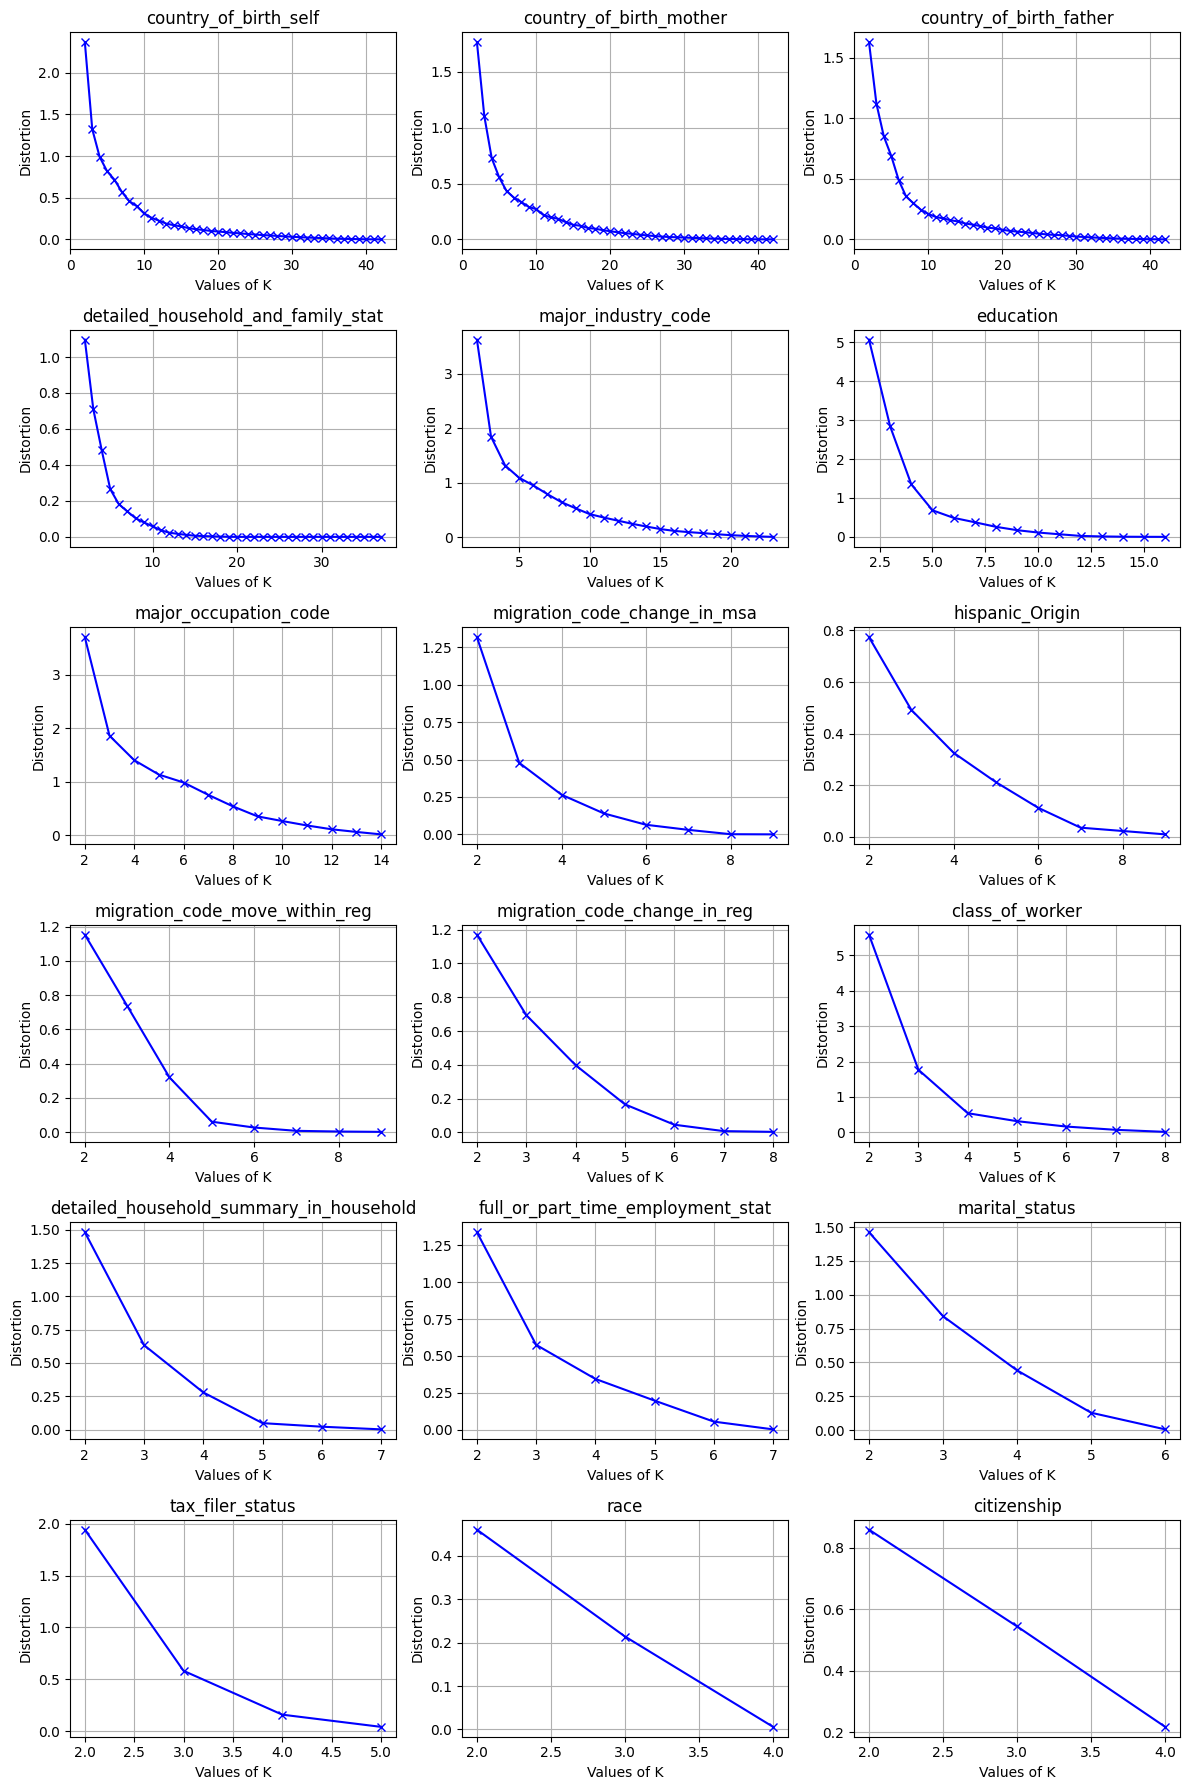

In [63]:
cols = string_cols

# Calculate the number of rows and columns for subplots
n_cols = 3  # Number of columns per row
n_rows = (len(cols) + n_cols - 1) // n_cols  # Calculate the number of rows needed

# Create subplots grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 18))
fig.subplots_adjust(hspace=0.5)

df_dict = dict()

for idx, col in enumerate(cols):

    categ_df = df_train_a[df_train_a['target']==1].groupby([col],as_index=False).size()
    categ_0 = df_train_a[df_train_a['target']==0]
    categ_0_grpd = categ_0[~categ_0[col].isin(categ_df[col].tolist())].groupby([col],as_index=False).size()
    categ_0_grpd['size'] = 0
    categ_df_01 = pd.concat([categ_df,categ_0_grpd])
    
    # categ_df
    total_df = df_train_a.groupby([col],as_index=False).size().rename(columns={'size':'total'})
    
    merged_df = pd.merge(categ_df_01,total_df,on=col)
    # print(categ_df.columns,total_df.columns)
    
    
    merged_df['%'] = (merged_df['size']*100/merged_df['total']).round(2)
    result = merged_df.sort_values(by=['%'],ascending=False)[[col,'%']].reset_index(drop=True)

    df_dict[col] = result
    
    distortions = []
    inertias = []
    mapping1 = {}
    mapping2 = {}
    K = range(2, len(result[col].unique()))
    
    for k in K:
    	# Building and fitting the model
    	kmeanModel = KMeans(n_clusters=k).fit(result[['%']].values)
    	#kmeanModel.fit(X_train_scaled)
    
    	distortions.append(sum(np.min(cdist(result[['%']].values, kmeanModel.cluster_centers_,
    										'euclidean'), axis=1)) / result[['%']].values.shape[0])
    	inertias.append(kmeanModel.inertia_)
    
    	mapping1[k] = sum(np.min(cdist(result[['%']].values, kmeanModel.cluster_centers_,
    								'euclidean'), axis=1)) / result[['%']].values.shape[0]
    	mapping2[k] = kmeanModel.inertia_

    # Calculate the subplot index for each column
    row_idx = idx // n_cols
    col_idx = idx % n_cols

    # Plot on the appropriate subplot
    plt.subplot(n_rows, n_cols, idx + 1)  # Specify the subplot position
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('Values of K')
    plt.ylabel('Distortion')
    plt.title(col)
    plt.grid(True)

# Remove empty subplots if the number of columns is not a multiple of 2
for i in range(len(cols), n_cols * n_rows):
    fig.delaxes(axes.flatten()[i])

# Adjust layout and show the plots
# plt.title('Elbow Method for columns')
plt.tight_layout()
plt.show()

##### Conclusion: 
##### Columns with high cardinality will be checked further e.g. 'country_of_birth_self'. 
##### Graphs with a clear elbow like curve can be easy to determine e.g. 'class_of_worker'. Here the elbow is formed at 4 clusters.
##### Hence we can bucketize the 'class_of_worker' column based on 5 groups

#### Example of a smooth range % column:
##### 'country_of_birth_self' is difficult to bucket (via data driven or intuition both)

In [82]:
# First % value represents ~28% of individuals from Holand-Netherlands earn above $50k income

col = 'country_of_birth_self'
result1 = df_dict[col]

result1[col] = result1[col].str.strip()

result1.drop(['clusts'],axis=True)

,country_of_birth_self,%
0,Holand-Netherlands,21.74
1,Iran,17.83
2,India,17.53
3,Scotland,17.33
4,Taiwan,15.50
5,England,12.83
6,France,12.40
7,Japan,12.12
8,Ireland,10.37
9,Greece,10.20


#### Example of clear buckets column:
##### Note: Bucketizing was a manual process for each categorical column based on the clusters from elbow method

In [85]:
col = 'education'
result = df_dict[col]
kmeanModel = KMeans(n_clusters = 5).fit(result[['%']].values)
result['clusts'] = kmeanModel.labels_

result[col] = result[col].str.strip()


# cluster_dict = {}
# for cluster in result['clusts'].unique():
#     cluster_dict[cluster] = result[result['clusts'] == cluster][col].tolist()

# print(cluster_dict)

result

,education,%,clusts
0,Prof school degree (MD DDS DVM LLB JD),54.05,1
1,Doctorate degree(PhD EdD),52.06,1
2,Masters degree(MA MS MEng MEd MSW MBA),31.48,2
3,Bachelors degree(BA AB BS),20.17,3
4,Associates degree-academic program,9.53,0
5,Associates degree-occup /vocational,7.83,0
6,Some college but no degree,6.79,0
7,High school graduate,4.30,0
8,12th grade no diploma,1.65,4
9,7th and 8th grade,1.14,4


#### Example observation:
##### Individuals with Professional degrees or PhD have the highest chance of having income above 50k (cluster 1)
##### Individuals with Master's degree (cluster 2) followed by Bachelor's degree (cluster 3) have a good chance of having income above 50k. etc.

##### Conclusion:
#####
##### High Cardinality and smooth range columns (discarded):
##### - country_of_birth_self
##### - country_of_birth_mother
##### - country_of_birth_father
##### - major_industry_code
#####
##### Smooth range columns (discarded)
##### - hispanic_Origin
##### - migration_code_move_within_reg
##### - migration_code_change_in_reg
##### - race
##### - citizenship
#####
##### Clustered based on Elbow method (graphs mentioned above):
##### - education -> 5 clusters
##### - detailed_household_summary_in_household -> 5 clusters
##### - marital_status -> 5 clusters
##### - class_of_worker -> 4 clusters
##### - major_occupation_code -> 3 clusters
##### - migration_code_change_in_msa -> 3 clusters
##### - full_or_part_time_employment_stat -> 3 clusters
##### - tax_filer_status -> 3 clusters
#####
##### Same as similar column's clusters (discard):
##### - detailed_household_and_family_stat -> similar to 5 clusters of 'detailed_household_summary_in_household' 

####
#### Analysis on Continuous Variables
##### (Not considering 'industry_code','occupation_code' as we are using major occupation code from category columns)

In [18]:
int64_columns = df_train_a.select_dtypes(['int64']).columns
int64_columns = [e for e in int64_columns if e not in ['year','industry_code','occupation_code']]

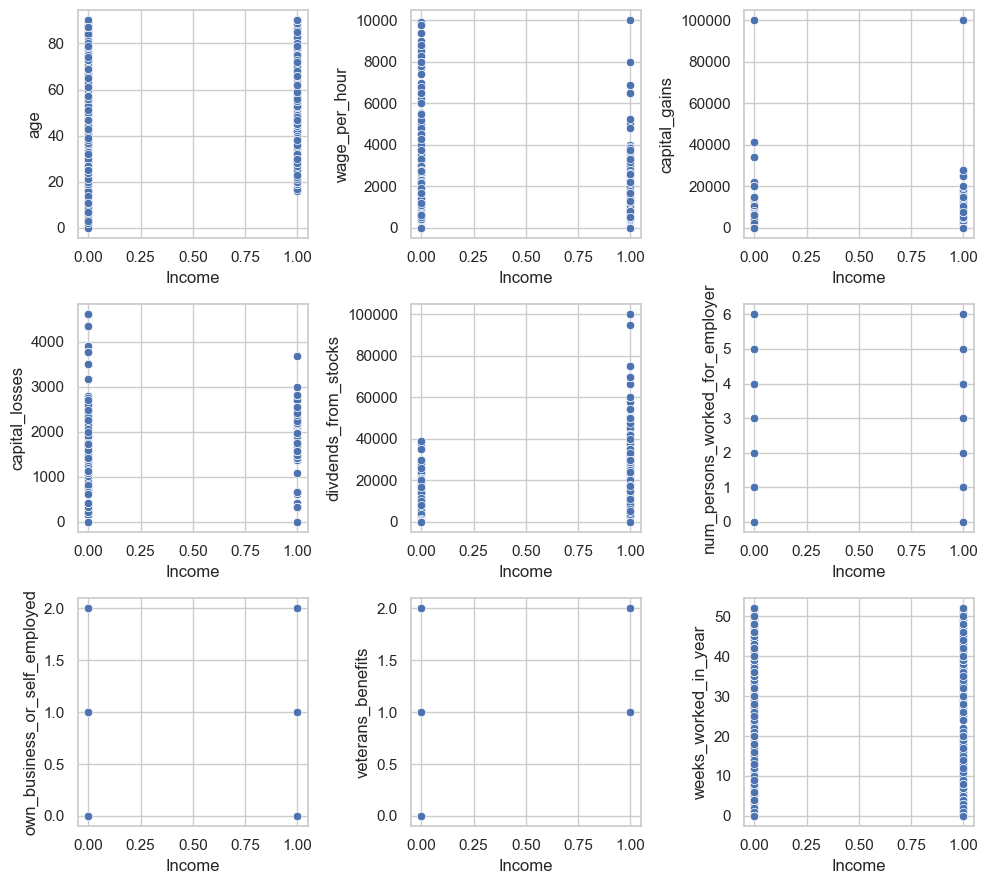

In [111]:
num_cols = 3
num_rows = int(len(int64_columns[:-1])/num_cols)

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 3*num_rows))
axes = np.array(axes).flatten()
# Iterate through continuous columns and create scatterplots
for i, col in enumerate(int64_columns[:-1]):
    row_idx = i
    ax = axes[row_idx]
    sns.scatterplot(x="target", y=col, data=df_train_a, ax=ax)
    ax.set_xlabel("Income")
    ax.set_ylabel(col)

plt.tight_layout()
plt.show()

##### Conclusion: 
##### - Age looks more concentrated at 18+ (working individuals) for income above 50k
##### - Dividends from stocks looks more concentrated from 0-40k for income below 50k
##### - These 2 columns along with others should be bucketized 

#### Age Distribution against Income

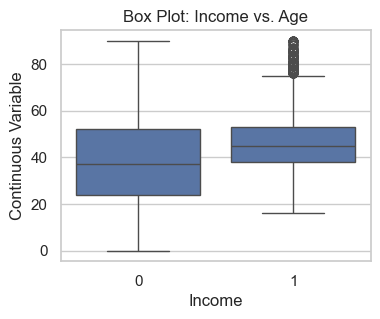

In [116]:
# Create a box plot
plt.figure(figsize=(4, 3))
sns.boxplot(x="target", y="age", data=df_train_a)
plt.xlabel("Income")
plt.ylabel("Continuous Variable")
plt.title("Box Plot: Income vs. Age")
plt.show()

##### Conclusion: Age should be bucketized in 4 groups:
##### - Early career : 0-24
##### - Mid senior career 25-37
##### - Executive / Senior career: 38-52
##### - Early to late retirement : 53+

### Bucketizing functions

In [20]:
df_train_a, df_test_a = age_bucket(df_train_a),age_bucket(df_test_a)
df_train_a, df_test_a = education_bucket(df_train_a),education_bucket(df_test_a)
df_train_a, df_test_a = married_bucket(df_train_a),married_bucket(df_test_a)
# df_train_a, df_test_a = race_bucket(df_train_a),race_bucket(df_test_a)
# df_train_a, df_test_a = hispanic_bucket(df_train_a),hispanic_bucket(df_test_a)
# df_train_a, df_test_a = birth_country_bucket(df_train_a),birth_country_bucket(df_test_a)
# df_train_a, df_test_a = citizen_bucket(df_train_a),citizen_bucket(df_test_a)
# df_train_a, df_test_a = capital_net(df_train_a),capital_net(df_test_a)
df_train_a, df_test_a = capital(df_train_a),capital(df_test_a)

df_train_a, df_test_a = worker_bucket(df_train_a),worker_bucket(df_test_a)
df_train_a, df_test_a = householder(df_train_a),householder(df_test_a)
df_train_a, df_test_a = tax(df_train_a),tax(df_test_a)
df_train_a, df_test_a = occupation(df_train_a),occupation(df_test_a)
df_train_a, df_test_a = ft_pt_func(df_train_a),ft_pt_func(df_test_a)
df_train_a, df_test_a = mig_msa(df_train_a),mig_msa(df_test_a)
df_train_a, df_test_a = wage_bucket(df_train_a),wage_bucket(df_test_a)
df_train_a, df_test_a = weeks_bucket(df_train_a),weeks_bucket(df_test_a)

In [21]:
df_train_a = df_train_a.drop(['industry_code', 'occupation_code', 'major_industry_code', 'race',
       'hispanic_Origin', 'detailed_household_and_family_stat',
       'migration_code_change_in_reg', 'migration_code_move_within_reg',
       'live_in_this_house_1_year_ago',
       'country_of_birth_father', 'country_of_birth_mother',
       'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', 'year'],axis=1)

df_test_a = df_test_a.drop(['industry_code', 'occupation_code', 'major_industry_code', 'race',
       'hispanic_Origin', 'detailed_household_and_family_stat',
       'migration_code_change_in_reg', 'migration_code_move_within_reg',
       'live_in_this_house_1_year_ago',
       'country_of_birth_father', 'country_of_birth_mother',
       'country_of_birth_self', 'citizenship', 'own_business_or_self_employed', 'year'],axis=1)

In [206]:
df_train_a.columns

Index(['sex', 'num_persons_worked_for_employer', 'veterans_benefits', 'target',
       'age_bucket', 'education_group', 'married_or_not',
       'capital_gains_bucket', 'capital_losses_bucket',
       'divdends_from_stocks_bucket', 'worker_class', 'household', 'tax',
       'prof', 'ft_pt_group', 'mig_msa_group', 'wage_bucket', 'weeks_bucket'],
      dtype='object')

In [239]:
piv = pivot_grp(df_train_a,'num_persons_worked_for_employer')
piv

target,num_persons_worked_for_employer,0%,1%,%difference
6,6,21.90,44.27,22.37
4,4,9.15,11.89,2.74
1,1,14.80,16.89,2.09
5,5,3.81,5.37,1.56
3,3,8.64,10.00,1.36
2,2,6.55,6.78,0.23
0,0,35.15,4.80,-30.35


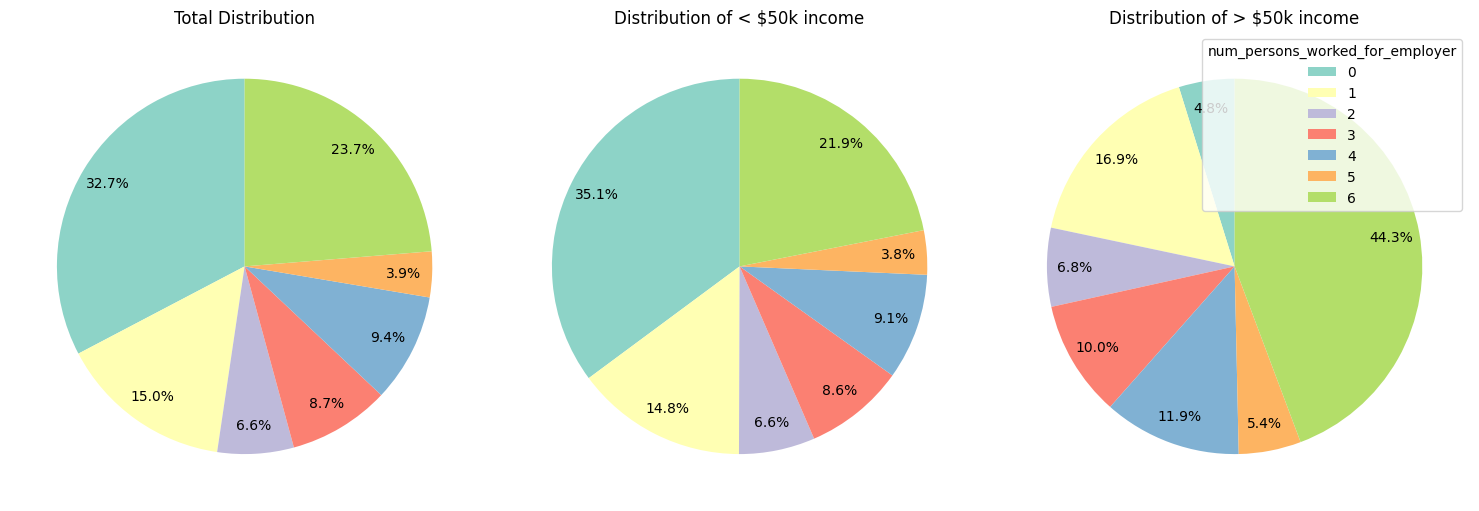

In [22]:
pie_plot('num_persons_worked_for_employer')

##### Conclusion:
##### - Individuals who work in larger firms have a 22% higher chance of earning above 50k

In [240]:
col = 'age_bucket'
piv = pivot_grp(df_train_a,col)
piv

target,age_bucket,0%,1%,%difference
2,38_52,23.85,48.82,24.97
3,53+,24.80,26.44,1.64
1,25_37,26.14,23.82,-2.32
0,0_24,25.21,0.91,-24.30


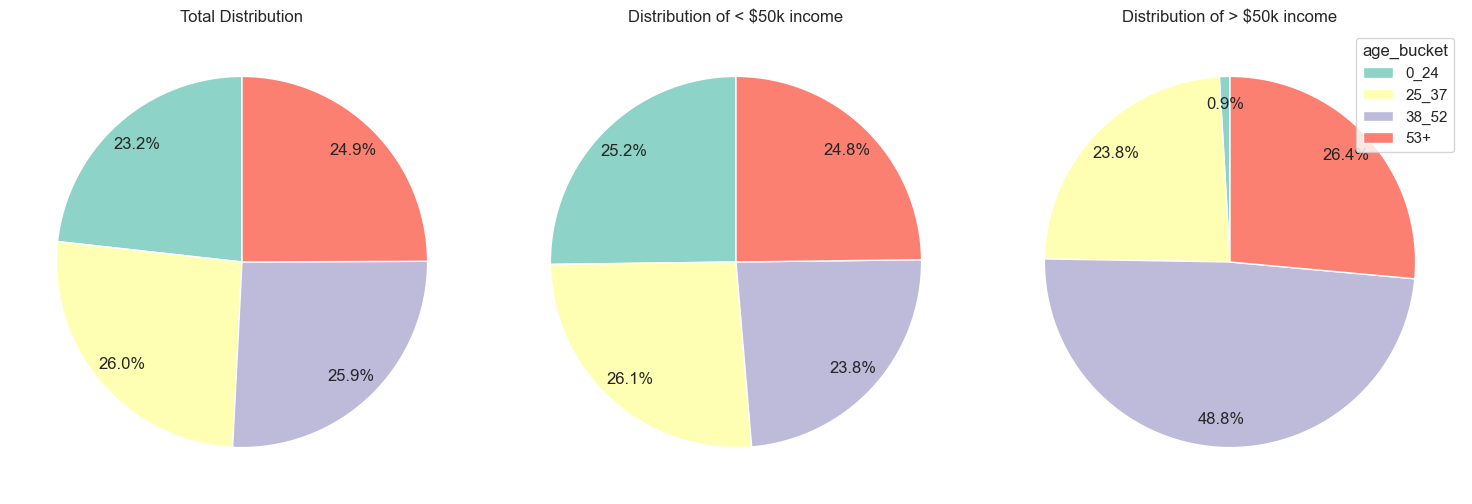

In [225]:
pie_plot('age_bucket')

##### Conclusion:
##### - Individuals who are in the age group 38-52 (senior/executives) have a 25% higher chance of earning above 50k

In [241]:
col = 'education_group'
piv = pivot_grp(df_train_a,col)
piv

target,education_group,0%,1%,%difference
2,bachelors,11.02,31.63,20.61
3,masters,3.15,16.44,13.29
4,profess,1.02,13.14,12.12
1,assoc_grd,53.41,36.27,-17.14
0,<_12th,31.41,2.52,-28.89


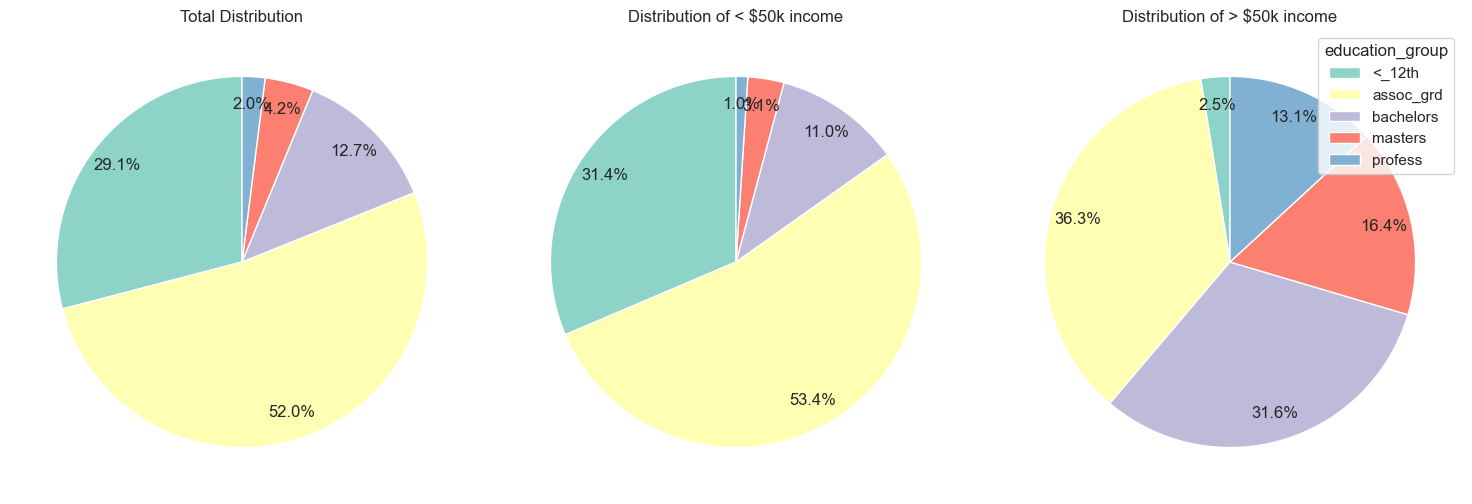

In [227]:
pie_plot('education_group')

##### Conclusion:
##### - Individuals who hold a bachelor's degree have a 21% higher chance of earning above 50k

In [242]:
col = 'married_or_not'
piv = pivot_grp(df_train_a,col)
piv

target,married_or_not,0%,1%,%difference
1,M_spouse_pr,48.57,77.52,28.95
2,divorced,8.14,8.61,0.47
0,M_spouse_ab,1.01,0.78,-0.23
4,sep_wid,8.41,3.94,-4.47
3,never_M_AF,33.87,9.15,-24.72


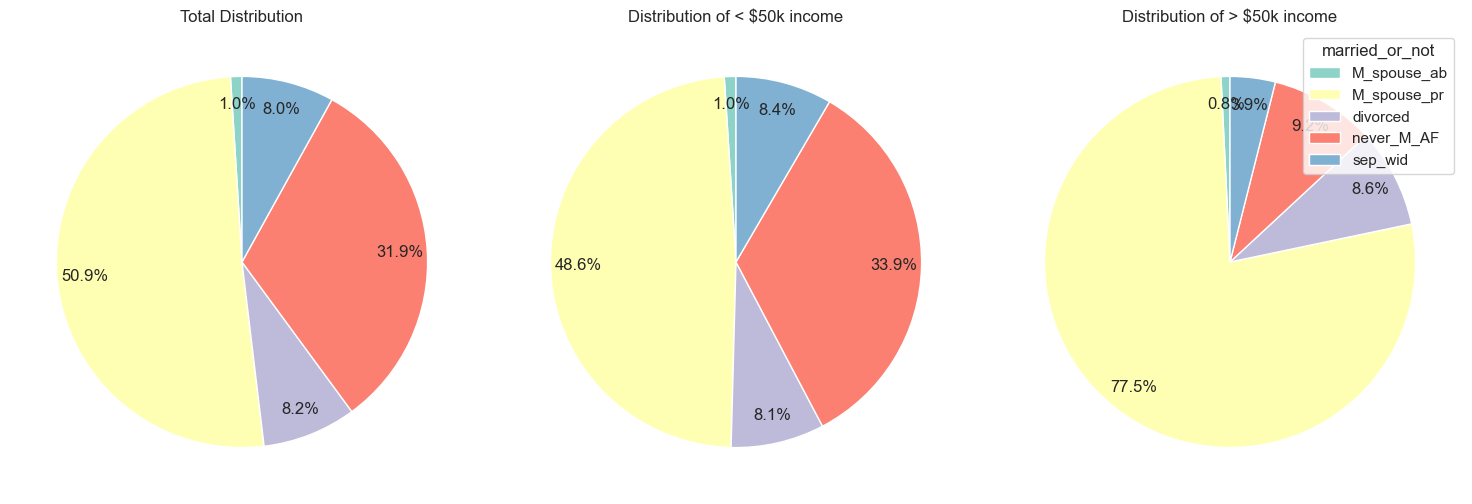

In [230]:
pie_plot('married_or_not')

##### Conclusion:
##### - Individuals who are married with spouse present have a 29% higher chance of earning above 50k

In [243]:
col = 'worker_class'
piv = pivot_grp(df_train_a,col)
piv

target,worker_class,0%,1%,%difference
2,self_gov_priv,58.55,78.71,20.16
3,self_incrp,1.51,9.16,7.65
0,federal,1.65,4.83,3.18
1,na_wo_pay,38.29,7.30,-30.99


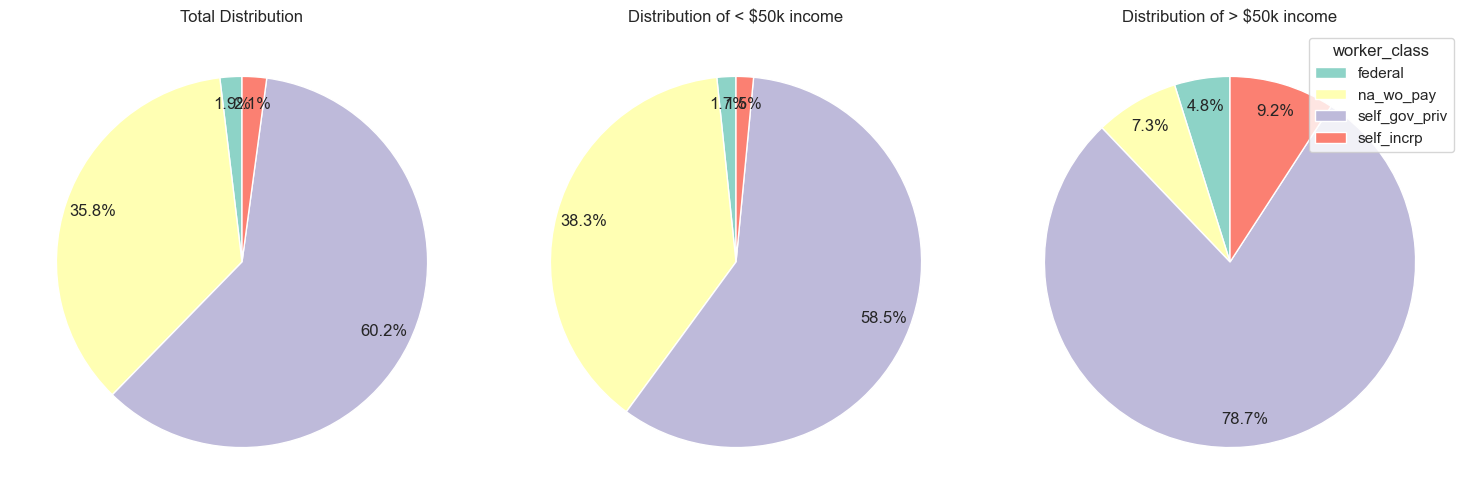

In [244]:
pie_plot('worker_class')

##### Conclusion:
##### - Individuals who own a business OR work for government have a 20% higher chance of earning above 50k

In [246]:
col = 'prof'
piv = pivot_grp(df_train_a,col)
piv

target,prof,0%,1%,%difference
0,exec_army,13.75,57.16,43.41
2,sales_tech_protect,16.87,25.03,8.16
1,primary,69.39,17.81,-51.58


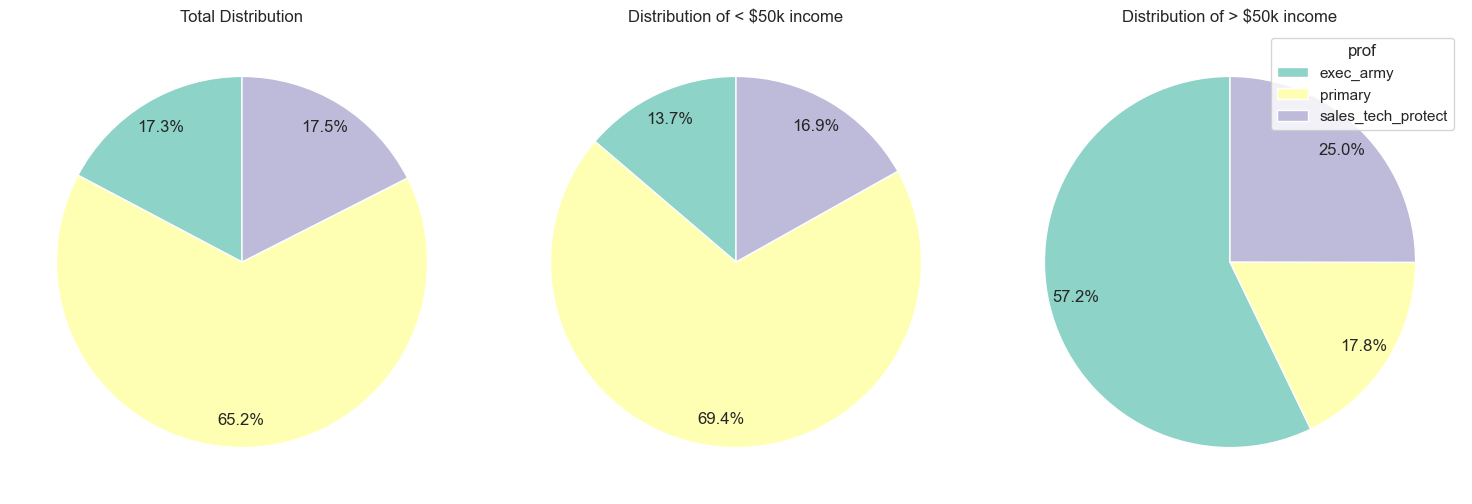

In [245]:
pie_plot('prof')

##### Conclusion:
##### - Individuals who are in the Army OR are Executives have a 43% higher chance of earning above 50k

In [248]:
col = 'household'
piv = pivot_grp(df_train_a,col)
piv

target,household,0%,1%,%difference
0,HH,44.21,77.95,33.74
2,spouse_norel,29.71,20.31,-9.40
1,other,26.08,1.74,-24.34


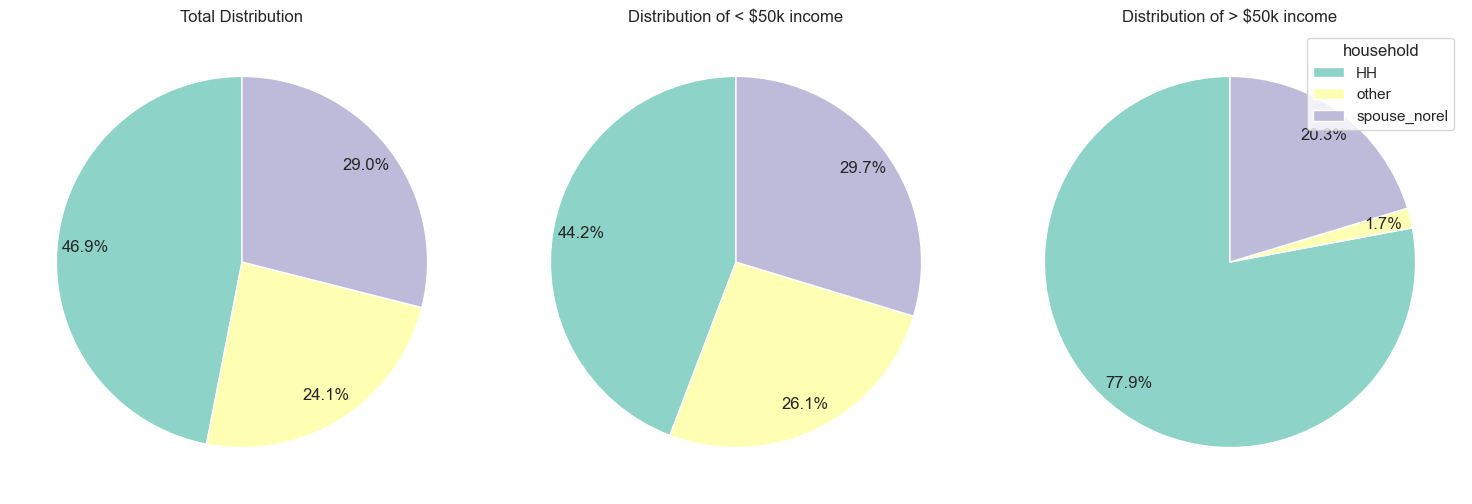

In [247]:
pie_plot('household')

##### Conclusion:
##### - Individuals who are Householders have a 34% higher chance of earning above 50k

In [250]:
col = 'tax'
piv = pivot_grp(df_train_a,col)
piv

target,tax,0%,1%,%difference
0,joint_both_under,39.36,71.48,32.12
2,rest,35.94,28.24,-7.70
1,non_filer,24.69,0.28,-24.41


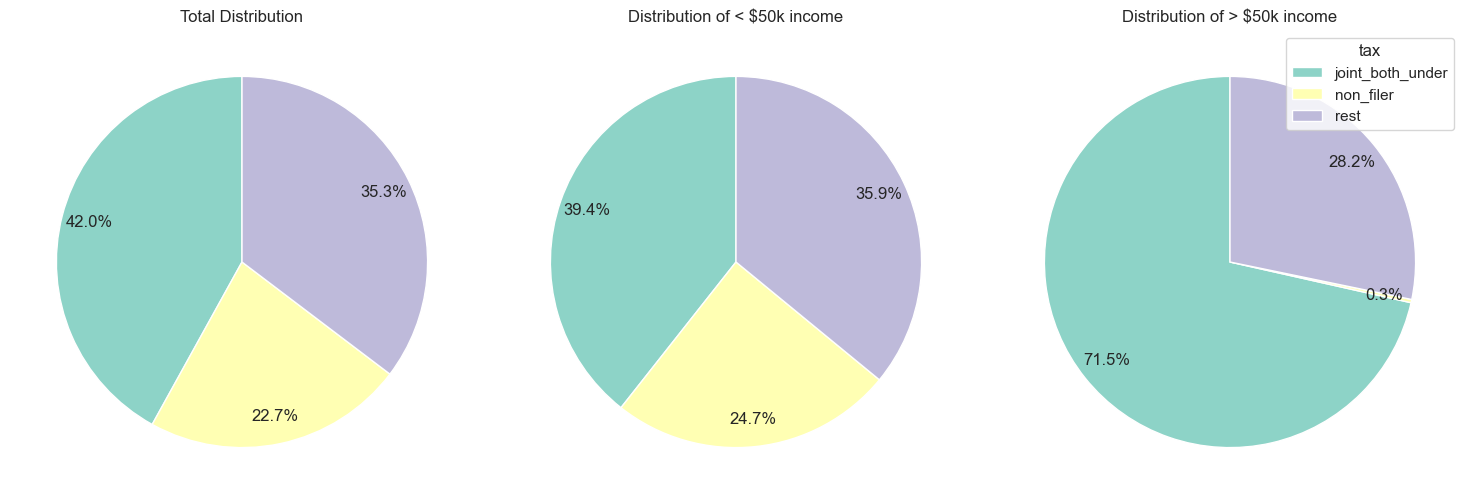

In [249]:
pie_plot('tax')

##### Conclusion:
##### - Individuals who are Joint filers and both under 65 have a 32% higher chance of earning above 50k

In [251]:
# pie_plot('ft_pt_group')

### Filter categorical and numerical columns 
#### (based on column importance from data-driven / intuitive approach)

In [23]:
# consider_cols_cat = ['worker_class','us_citizen','immigrant','immigrant_parents','hispanic_or_other','white_or_nonwhite','married_or_not',
#                      'education_group','age_bucket','sex']
# consider_cols_int = ['capital_net','weeks_worked_in_year','num_persons_worked_for_employer','wage_per_hour']

# consider_cols_cat = ['sex','age_bucket','household', 'tax', 'prof','married_or_not','hispanic_or_other',
#                     'white_or_nonwhite']
# consider_cols_int = ['weeks_worked_in_year','num_persons_worked_for_employer','capital_net']

consider_cols_cat = ['sex', 'num_persons_worked_for_employer',
                       'age_bucket', 'education_group', 'married_or_not',
                       'capital_gains_bucket', 'capital_losses_bucket',
                       'divdends_from_stocks_bucket', 'worker_class', 'household', 'tax',
                       'prof', 'wage_bucket', 'weeks_bucket']

consider_cols_int = []

input_cols = consider_cols_int + consider_cols_cat
target_col = 'target'

all_cols = input_cols + ['target']

df_train_a['num_persons_worked_for_employer'] = df_train_a['num_persons_worked_for_employer'].astype(str)
df_test_a['num_persons_worked_for_employer'] = df_test_a['num_persons_worked_for_employer'].astype(str)

# df_train_a_tmp = copy.deepcopy(df_train_a)
df_train_a = df_train_a[all_cols]
df_test_a = df_test_a[all_cols]

### One hot encoding

In [24]:
for col in consider_cols_cat:
    cat_df = pd.get_dummies(df_train_a[col],drop_first=True).rename(columns=lambda x:col+'_' +str(x))
    del df_train_a[col]
    df_train_a = pd.concat([df_train_a, cat_df], axis=1)

for col in consider_cols_cat:
    cat_df = pd.get_dummies(df_test_a[col],drop_first=True).rename(columns=lambda x:col+'_' +str(x))
    del df_test_a[col]
    df_test_a = pd.concat([df_test_a, cat_df], axis=1)

In [28]:
# # Checkpoint feature engineered data

# df_train_a.to_csv('df_train_a.csv',index=False)
# df_test_a.to_csv('df_test_a.csv',index=False)

# # del outer
# # del df_train
# # del df_test
# # del intersected_df

# df_train_a = pd.read_csv('df_train_a.csv')
# df_test_a = pd.read_csv('df_test_a.csv')

In [27]:
input_cols1 = [x for x in df_train_a.columns if x!='target']
df_train_a['target'] = df_train_a['target'].astype(int)
df_test_a['target'] = df_test_a['target'].astype(int)

#### Converting dataframe to multidimensional arrays for model compatibility

In [28]:
X_train = df_train_a[input_cols1].values
y_train = df_train_a[target_col].values
X_test = df_test_a[input_cols1].values
y_test = df_test_a[target_col].values

Counter(y_train),Counter(y_test)

(Counter({0: 140520, 1: 12367}), Counter({0: 93571, 1: 6186}))

#### Checking if train and test are from same distribution

In [34]:
# Create labels to distinguish between training (1) and test (0) sets
y_train_label = np.ones(X_train.shape[0])
y_test_label = np.zeros(X_test.shape[0])

# Combine the labeled data
X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train_label, y_test_label))

# Train a simple binary classification model (Logistic Regression)
model = LogisticRegression()
model.fit(X_combined, y_combined)

# Predict labels for the combined dataset
y_pred = model.predict(X_combined)

# Calculate accuracy to assess how well the model distinguishes the sets
accuracy = accuracy_score(y_combined, y_pred)

print("Accuracy of the model in distinguishing sets:", accuracy)

print("Since it is not too close to 50%, this suggets that there maybe some difference in distribution between train and test sets, but accuracy score with a basic model doesn't necessarily provide much info on this")

Accuracy of the model in distinguishing sets: 0.6426236126723769
Since it is not too close to 50%, this suggets that there maybe some difference in distribution between train and test sets, but accuracy score with a basic model doesn't necessarily provide much info on this


### Scaling and Standardization (not used in tree based models)

In [35]:
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
pipeline.fit(X_train)
X_train_scaled = pipeline.transform(X_train)
X_test_scaled = pipeline.transform(X_test)

### Dealing with Class Imbalance (undersampling will be tested on all models)

In [36]:
# oversample = SMOTE()
# # X_over, y_over = oversample.fit_resample(X_train, y_train)
# X_over_scaled, y_over = oversample.fit_resample(X_train_scaled, y_train)
# Counter(y_over)

### Undersampling majority class randomly
#### Note: Stratified + clustered under-sampling was tried but provided poor results

In [37]:
# undersample = RandomUnderSampler(sampling_strategy=0.2)
undersample = RandomUnderSampler(sampling_strategy='majority')
X_under_scaled, y_under = undersample.fit_resample(X_train_scaled, y_train)
X_under, y_under = undersample.fit_resample(X_train, y_train)
Counter(y_under)

Counter({0: 12367, 1: 12367})

## Models

### Logistic regression with Hyperparameter tuning on original data

In [51]:
grid_result = hyper_lr(X_train,y_train)
clf2 = lr_report(grid_result,X_train,y_train)

# Save the trained model to a file
path = 'models/lr.joblib'
save_model(clf2,path)

# Load the saved model from the file
clf2 = read_model(path)

Best: 0.705803 using {'solver': 'lbfgs', 'penalty': 'l2', 'C': 545.5594781168514}
55.75216007232666 seconds
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     93571
           1       1.00      0.00      0.01      6186

    accuracy                           0.94     99757
   macro avg       0.97      0.50      0.49     99757
weighted avg       0.94      0.94      0.91     99757



##### **Conclusion:** 
##### The model is not able to correctly predict any of the sample with 'income above 50k'. 
##### A macro average f1-score (definition mentioned in the next conclusion) with 0.49 suggests that the model performs similar to a random model which labels above and below 50k income randomly

### Logistic Regression on scaled data

In [54]:
grid_result = hyper_lr(X_train_scaled,y_train)
clf3 = lr_report(grid_result,X_train_scaled,y_train)

# Save the trained model to a file
path = 'models/lr_scaled.joblib'
save_model(clf3,path)

# Load the saved model from the file
clf3 = read_model(path)

Best: 0.704847 using {'solver': 'saga', 'penalty': 'none', 'C': 11.288378916846883}
87.6418206691742 seconds
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     93571
           1       0.68      0.34      0.45      6186

    accuracy                           0.95     99757
   macro avg       0.82      0.66      0.71     99757
weighted avg       0.94      0.95      0.94     99757



##### **Conclusion for Logistic regression results:**
#####
##### Precision:

##### Precision is a measure of how accurate our model is when it predicts a particular category (in this case, 0 or 1).
##### For category 0 (below 50k income), the model's predictions are 96% accurate. This means that when the model predicts that someone's income is below 50k, it is correct 96% of the time.
##### For category 1 (above 50k income), the model's predictions are 99% accurate. This means that when the model predicts that someone's income is below 50k, it is correct 99% of the time.
#####
##### Recall:

##### Recall is a measure of how well our model captures or finds all the instances of a particular category.
##### For category 0 (below 50k income), the model predicted 68% of all the people with incomes below 50k. So, it misses 32% of them.
##### For category 1 (above 50k income), the model only predicted 34% of all the people with incomes above 50k. So, it missed ~70% of them.
#####
##### Macro Average Recall:
##### Gives equal importance to each class, regardless of their size or frequenc
#####
##### Weighted Average Precision:
##### Gives importance of each class based on its size or frequency.
##### However, when averaging, larger classes have more influence on the final score than smaller classes.
#####
##### Understanding that the goal is to best classify both 'income above 50k' and 'income below 50k', so focusing on one class will be ineffective
##### In this case, focusing on Macro Average F1-score (harmonic mean of macro avg precision and recall) will be the right evaluation.y.

#####
### Logistic Regression on under-sampled data

In [55]:
grid_result_under = hyper_lr(X_under_scaled,y_under)
clf3_under = lr_report(grid_result_under,X_under_scaled,y_under)

# Save the trained model to a file
path = 'models/lr_under.joblib'
save_model(clf3_under,path)

# Load the saved model from the file
clf3_under = read_model(path)

Best: 0.835708 using {'solver': 'lbfgs', 'penalty': 'none', 'C': 0.23357214690901212}
18.93530535697937 seconds
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     93571
           1       0.29      0.86      0.44      6186

    accuracy                           0.86     99757
   macro avg       0.64      0.86      0.68     99757
weighted avg       0.95      0.86      0.89     99757



##### Conclusion:
##### The updated model gave more importance to predicting above category 1 (above 50k income), so for category 1, to predict someone's income is above 50k, it is correct 29% of the time.

##### In this process the recall went high (0.86) i.e. the model correctly predicted 86% of all the people with incomes above 50k
##### The harmonic mean of precision and recall is still similar
##### The macro avg f1-score is not better than the model trained on non-undersampled data because under-sampling may remove important information. 

In [38]:
log_pred_probab = clf3.predict_proba(X_test)
# calculate roc curves
log_pred_probab = log_pred_probab[:,1]
fpr, tpr, thresholds = roc_curve(y_test, log_pred_probab)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.738802, G-Mean=0.853


In [86]:
log_pred_probab = clf3.predict_proba(X_test_scaled)
lr_predictions = [1 if i >= 0.34 else 0 for i in log_pred_probab[:, -1]]
print(classification_report(y_test, lr_predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     93571
           1       0.56      0.50      0.53      6186

    accuracy                           0.94     99757
   macro avg       0.76      0.74      0.75     99757
weighted avg       0.94      0.94      0.94     99757



##### Conclusion:
##### The macro avg f1-score is 4% better than the previous 2 logistic regression models.

#### SVM

In [294]:
# svm_clf = svm.SVC(kernel='rbf', C=1, gamma=1) 

# svm_clf.fit(X_under_scaled, y_under)
# y_pred3 = svm_clf.predict(X_test)
# print(classification_report(y_test, y_pred3))

              precision    recall  f1-score   support

           0       0.96      0.90      0.93     93571
           1       0.23      0.44      0.30      6186

    accuracy                           0.87     99757
   macro avg       0.59      0.67      0.61     99757
weighted avg       0.91      0.87      0.89     99757



### Random Forest Classifier
#### Hyperparameter tuning RF with RandomizedSearchCV

In [57]:
random_result = hyper_rf(X_under,y_under,7,3,None)
rf = rf_report(random_result,X_under,y_under)

# Save the trained model to a file
path = 'models/rf_under.joblib'
save_model(rf,path)

# Load the saved model from the file
rf = read_model(path)

Best: 0.837098 using {'n_estimators': 50, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2', 'max_depth': 30, 'bootstrap': True}
32.80785036087036 seconds
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     93571
           1       0.29      0.86      0.43      6186

    accuracy                           0.86     99757
   macro avg       0.64      0.86      0.67     99757
weighted avg       0.95      0.86      0.89     99757



#### Conclusion:
##### Precision:

##### For category 0 (below 50k income), the model's predictions are 99% accurate. This means that when the model predicts that someone's income is below 50k, it is correct 99% of the time.
##### For category 1 (above 50k income), the model's predictions are less accurate, at 28%. So, when the model predicts that someone's income is above 50k, it is correct 29% of the time.
#####
##### Recall:

##### For category 0 (below 50k income), the model is good at finding 86% of all the people with incomes below 50k. So, it doesn't miss many of them.
##### For category 1 (above 50k income), the model is also good at finding 86% of all the people with incomes above 50k. So, it doesn't miss many of them either.
#####
##### macro avg F1-Score:
##### Not better than the tuned logistic regression model

#### Changing RF prediction threshold 
#### (To balance recall and precision, but depends on which class is more important to predict)

In [62]:
y_pred_probab = rf.predict_proba(X_test)
# calculate roc curves
y_pred_probab = y_pred_probab[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probab)

# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))

ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

Best Threshold=0.486645, G-Mean=0.861


In [61]:
y_pred_probab = rf.predict_proba(X_test)
rf_predictions = [1 if i >= 0.8 else 0 for i in y_pred_probab[:, -1]]
print(classification_report(y_test, rf_predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     93571
           1       0.53      0.52      0.53      6186

    accuracy                           0.94     99757
   macro avg       0.75      0.75      0.75     99757
weighted avg       0.94      0.94      0.94     99757



##### Conclusion:
##### The macro avg f1-score is same as that of the logistic regression model.

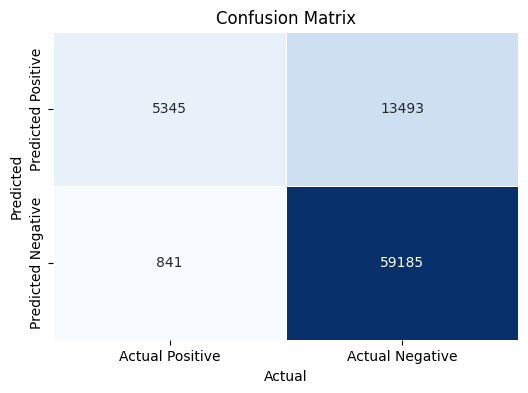

In [176]:
tn, fp, fn, tp = confusion_matrix(y_test, rf_predictions).ravel()
tn, fp, fn, tp = confusion_matrix(y_test, y_pred4).ravel()

# Create the confusion matrix as a aDataFrame
confusion_df = pd.DataFrame({'Actual Positive': [tp, fn], 'Actual Negative': [fp, tn]}, index=['Predicted Positive', 'Predicted Negative'])

# Plot the confusion matrix using Seaborn's heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='Blues', cbar=False, linewidths=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

### RF Feature importance

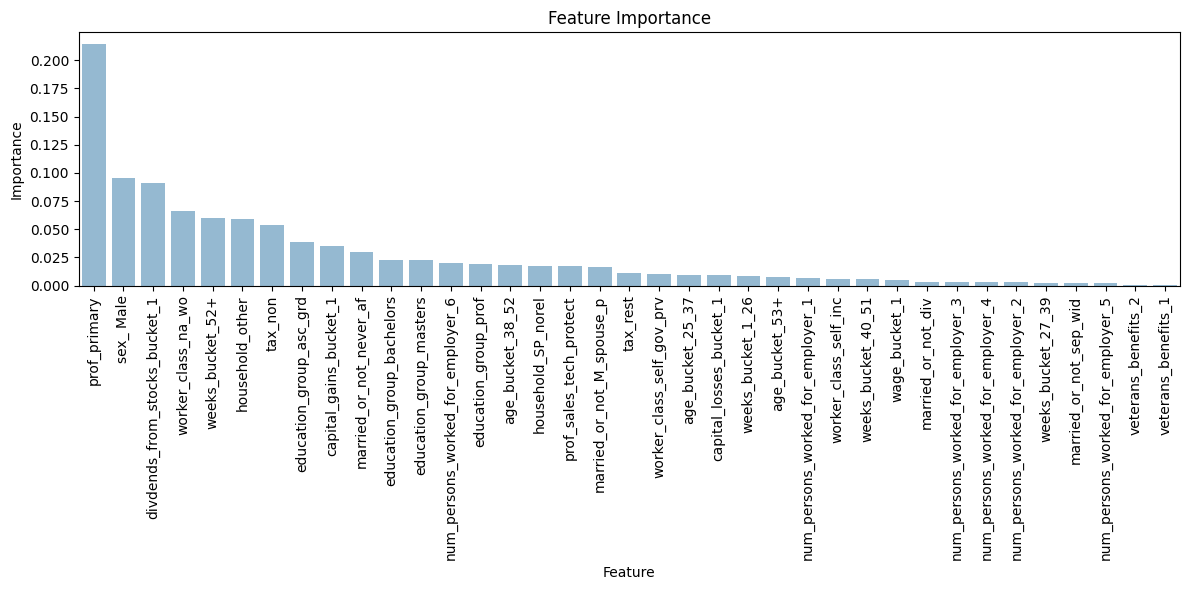

In [181]:
feats = {}
for feature, importance in zip(df_train_a[input_cols1].columns, rf.feature_importances_):
    feats[feature] = importance 

sorted(feats.items(), key=lambda x:x[1], reverse=True)
# pd.DataFrame(sorted(feats.items(), key=lambda x:x[1], reverse=True))[0].to_list()
df = pd.DataFrame(sorted(feats.items(), key=lambda x:x[1], reverse=True)).rename(columns={0:'Feature',1:'Importance'})

# Set a blue color palette
sns.set_palette("Blues_d")

# Create the barplot
plt.figure(figsize=(12, 6))
sns.barplot(x="Feature", y="Importance", data=df)
plt.xticks(rotation=90)  # Rotate x-axis labels for readability
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.tight_layout()

# Show the plot
plt.show()

##### Conclusion for RF feature importance:
##### - Profession is the most important feature in predicting income level 
##### - Other important features: Sex, Dividends from stocks, Worker class, Household, Tax filer, Education group and Capital gains

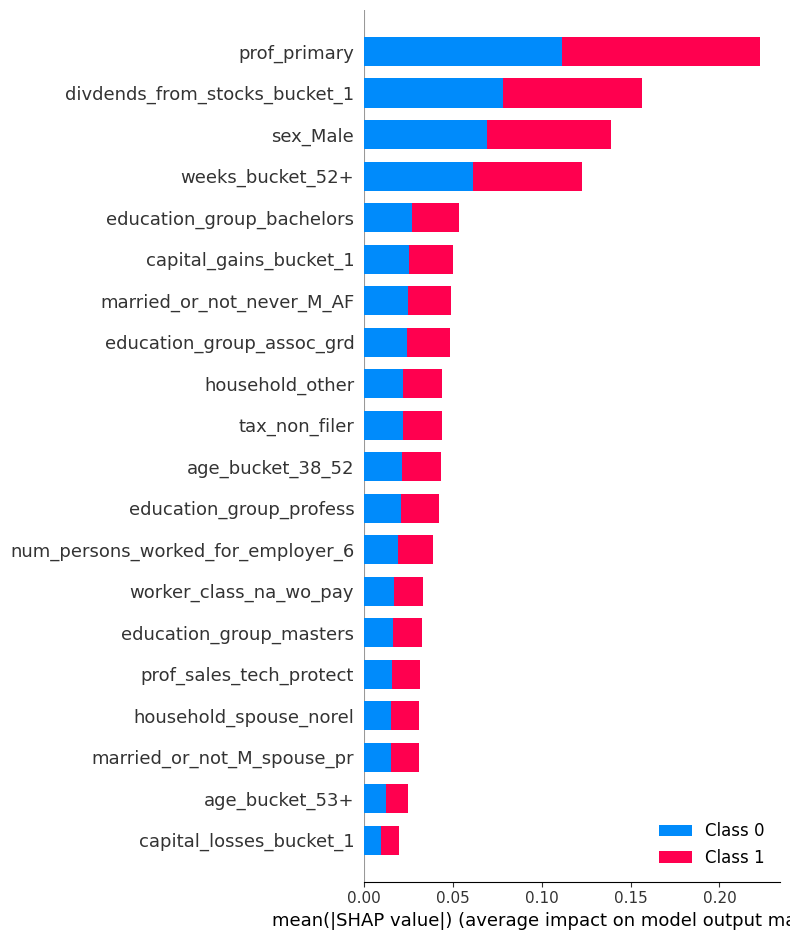

In [25]:
feature_names = list(df_train_a[input_cols1].columns)

sample_indices = random.sample(range(len(X_under)), 100)
X_sample = X_under[sample_indices]

shap_values = calculate_shap_values(random_result.best_estimator_, X_sample)

plot_shap_values(shap_values, feature_names)

##### Conclusion:
##### Though the feature importance the strength of the features in classification, the SHAP values provide a bifurcation between which feature holds stronger impact on each class.
##### In this case, none of the features seem to have any strong impact in defining income < or > 50k

### LightGBM with GridSearchCV

In [68]:
best_params_lgbm = hyper_lgb(X_under,y_under)
lgbm_classifier = lgb_report(X_under,y_under,best_params_lgbm)

# Save the trained model to a file
path = 'models/lgb_under.joblib'
save_model(lgbm_classifier,path)

# Load the saved model from the file
lgbm_classifier = read_model(path)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 12367, number of negative: 12367
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002116 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 70
[LightGBM] [Info] Number of data points in the train set: 24734, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best Parameters: {'n_estimators': 50, 'min_child_samples': 10, 'max_depth': 20, 'learning_rate': 0.1}
Best F1 Score: 0.8401611800801926
total time: 24.602479219436646
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set

In [69]:
y_pred_probab_lgbm = lgbm_classifier.predict_proba(X_test)
lgbm_predictions = [1 if i >= 0.79 else 0 for i in y_pred_probab_lgbm[:, -1]]
print(classification_report(y_test, lgbm_predictions))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     93571
           1       0.48      0.62      0.54      6186

    accuracy                           0.94     99757
   macro avg       0.73      0.79      0.75     99757
weighted avg       0.94      0.94      0.94     99757



##### Conclusion:
##### The macro avg f1-score is same as that of the logistic regression and Random Forest models.

In [66]:
y_pred6 = lgbm_classifier.predict(X_test)
df_test_a[(y_test==0)&(y_pred6==1)]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


,target,sex_Male,num_persons_worked_for_employer_1,num_persons_worked_for_employer_2,num_persons_worked_for_employer_3,num_persons_worked_for_employer_4,num_persons_worked_for_employer_5,num_persons_worked_for_employer_6,age_bucket_25_37,age_bucket_38_52,age_bucket_53+,education_group_assoc_grd,education_group_bachelors,education_group_masters,education_group_profess,married_or_not_M_spouse_pr,married_or_not_divorced,married_or_not_never_M_AF,married_or_not_sep_wid,capital_gains_bucket_1,capital_losses_bucket_1,divdends_from_stocks_bucket_1,worker_class_na_wo_pay,worker_class_self_gov_priv,worker_class_self_incrp,household_other,household_spouse_norel,tax_non_filer,tax_rest,prof_primary,prof_sales_tech_protect,wage_bucket_1,weeks_bucket_1_26,weeks_bucket_27_39,weeks_bucket_40_51,weeks_bucket_52+
8,0,True,True,False,False,False,False,False,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True
22,0,False,False,False,False,False,False,True,False,True,False,True,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,True
24,0,True,True,False,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,True,True,False,False,False,True
26,0,True,False,True,False,False,False,False,False,True,False,True,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False,False,True
29,0,True,False,False,False,False,False,True,False,True,False,True,False,False,False,True,False,False,False,True,False,True,False,True,False,False,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99693,0,True,False,False,True,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False,True,False,False,True,False,False,True,False,True,True,False,False,False,False,False,True
99727,0,True,True,False,False,False,False,False,False,False,True,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False
99731,0,True,False,False,True,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,True,False,True,False,False,True,False,True,False,True,True,False,False,False,True
99739,0,True,False,False,False,False,False,True,False,False,True,False,False,True,False,True,False,False,False,False,True,True,False,True,False,False,False,False,False,False,True,False,False,False,False,True


##### <font color='blue'> Note: This was just to eyeball what cases are causing false positives. </font>
##### <font color='blue'> As per the buckets, it makes sense for the model to classify these individuals as above income 50k. But in the test data these are with income less than 50k. </font>
##### <font color='blue'> This is potentially pointing towards a different approach on bucketizing the census features </font>

### XGB with RandomizedSearchCV

In [71]:
xgb_best_params = hyper_xgb(X_under,y_under)
xgb_hyper = xgb_report(X_under,y_under,xgb_best_params)

# Save the trained model to a file
path = 'models/xgb_under.joblib'
save_model(xgb_hyper,path)

# Load the saved model from the file
xgb_hyper = read_model(path)

Best: 0.826345 using {'max_depth': 4, 'min_child_weight': 7, 'n_estimators': 50, 'subsample': 0.8}
              precision    recall  f1-score   support

           0       0.99      0.86      0.92     93571
           1       0.29      0.86      0.44      6186

    accuracy                           0.86     99757
   macro avg       0.64      0.86      0.68     99757
weighted avg       0.95      0.86      0.89     99757



In [72]:
y_pred_probab_xgm = xgb_hyper.predict_proba(X_test)
xgb_predictions = [1 if i >= 0.845 else 0 for i in y_pred_probab_xgm[:, -1]]
print(classification_report(y_test, xgb_predictions))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     93571
           1       0.54      0.54      0.54      6186

    accuracy                           0.94     99757
   macro avg       0.76      0.76      0.76     99757
weighted avg       0.94      0.94      0.94     99757



##### Conclusion:
##### The macro avg f1-score is 1% better than that of the logistic regression, Random Forest and LightGBM models.

### Autoencoders.

#### A semisupervised approach
##### Using an autoencoder on the majority class helps simplify and distill the information, making it easier for the model to identify patterns and anomalies in the data. 
##### This can lead to better classification results, especially for the minority class, by enhancing the model's ability to recognize rare and important features.
##### Then feeding these features to a simple classification model to identify classes

In [73]:
input_dim = X_train_scaled.shape[1]
encoding_dim = 10  
input_layer = keras.Input(shape=(input_dim,))

encoder = keras.layers.Dense(encoding_dim, activation='relu')(input_layer)
encoder_model = keras.Model(inputs=input_layer, outputs=encoder)

decoder = keras.layers.Dense(input_dim, activation='sigmoid')(encoder)
decoder_model = keras.Model(inputs=encoder, outputs=decoder)


autoencoder = keras.Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Training the Autoencoder
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, shuffle=True,
                validation_data=(X_test_scaled, X_test_scaled))

# Creating the Classification Model
classification_model = keras.Sequential()
classification_model.add(encoder_model)  # Reuse the encoder part from the autoencoder
classification_model.add(keras.layers.Dense(1, activation='sigmoid'))

classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the Classification Model
classification_model.fit(X_train_scaled, y_train, epochs=50, batch_size=100, shuffle=True, validation_data=(X_test_scaled, y_test))


# autoencoder.fit(X_train_scaled[y_train == 0], X_train_scaled[y_train == 0], epochs=50, batch_size=32, shuffle=True,
#                 validation_data=(X_test_scaled[y_test == 0], X_test_scaled[y_test == 0]))

# classification_model = keras.Sequential()
# classification_model.add(encoder_model)
# classification_model.add(keras.layers.Dense(1, activation='sigmoid'))

# classification_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# classification_model.fit(X_train_scaled, X_test_scaled, epochs=50, batch_size=32, shuffle=True, validation_data=(X_test_scaled, y_test))

Epoch 1/50
4778/4778 [==============================] - 17s 3ms/step - loss: 0.0291 - val_loss: 0.0122
Epoch 2/50
4778/4778 [==============================] - 16s 3ms/step - loss: 0.0138 - val_loss: 0.0105
Epoch 3/50
4778/4778 [==============================] - 15s 3ms/step - loss: 0.0128 - val_loss: 0.0100
Epoch 4/50
4778/4778 [==============================] - 15s 3ms/step - loss: 0.0123 - val_loss: 0.0096
Epoch 5/50
4778/4778 [==============================] - 16s 3ms/step - loss: 0.0118 - val_loss: 0.0092
Epoch 6/50
4778/4778 [==============================] - 15s 3ms/step - loss: 0.0114 - val_loss: 0.0089
Epoch 7/50
4778/4778 [==============================] - 15s 3ms/step - loss: 0.0109 - val_loss: 0.0085
Epoch 8/50
4778/4778 [==============================] - 16s 3ms/step - loss: 0.0105 - val_loss: 0.0081
Epoch 9/50
4778/4778 [==============================] - 15s 3ms/step - loss: 0.0100 - val_loss: 0.0078
Epoch 10/50
4778/4778 [==============================] - 16s 3ms/step - l

In [78]:
auto_preds = classification_model.predict(X_test_scaled)
y_preds_auto = [1 if x >= 0.25 else 0 for x in auto_preds]
print(classification_report(y_test, y_preds_auto))

3118/3118 [==============================] - 2s 644us/step
              precision    recall  f1-score   support

           0       0.97      0.96      0.97     93571
           1       0.51      0.58      0.54      6186

    accuracy                           0.94     99757
   macro avg       0.74      0.77      0.75     99757
weighted avg       0.94      0.94      0.94     99757



In [118]:
from tensorflow.keras.models import load_model

# Define the paths for saving and loading the model
autoencoder_model_path = 'models/autoencoder_model.h5'
classification_model_path = 'models/classification_model.h5'

# Save the models
autoencoder.save(autoencoder_model_path)
classification_model.save(classification_model_path)

# Load the models
autoencoder = load_model(autoencoder_model_path)
classification_model = load_model(classification_model_path)

##### Conclusion
##### The model did not perform better than XGBoost in terms of f1-score macro avg

### Stacked Majority Model 
#### (Majority voting in predictions)

In [98]:
y_pred_lr = clf3.predict(X_test_scaled)
y_pred_rf = rf.predict(X_test)
y_pred_lgbm = lgbm_classifier.predict(X_test)
y_pred_xgm = xgb_hyper.predict(X_test)
y_auto_preds = classification_model.predict(X_test_scaled)

majority_predictions = majority_vote(y_pred_lr, y_pred_rf, y_pred_lgbm,y_pred_xgm,y_auto_preds)
len(majority_predictions)

# Counter(majority_predictions),Counter(rf_predictions),Counter(lgbm_predictions),Counter(xgb_predictions)

print(classification_report(y_test, majority_predictions))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
3118/3118 [==============================] - 2s 650us/step
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     93571
           1       0.31      0.84      0.45      6186

    accuracy                           0.87     99757
   macro avg       0.65      0.86      0.69     99757
weighted avg       0.95      0.87      0.90     99757



In [106]:
stacked_majority_predictions = [1 if i >= 0.9 else 0 for i in majority_predictions]
print(classification_report(y_test, stacked_majority_predictions)) # there is an issue in majority predictions threshold tuning

              precision    recall  f1-score   support

           0       0.99      0.87      0.93     93571
           1       0.31      0.84      0.45      6186

    accuracy                           0.87     99757
   macro avg       0.65      0.86      0.69     99757
weighted avg       0.95      0.87      0.90     99757



##### Conclusion:
##### The stacked models did not perform better than XGBoost in terms of f1-score macro avg (some issue in threshold tuning)

### Stacked Mean Model 
#### (Mean of classification probabilities in predictions)

In [97]:
y_pred_probab_lr = clf3.predict_proba(X_test_scaled)
y_pred_probab_rf = rf.predict_proba(X_test)
y_pred_probab_lgbm = lgbm_classifier.predict_proba(X_test)
y_pred_probab_xgm = xgb_hyper.predict_proba(X_test)
y_auto_preds = classification_model.predict(X_test_scaled)

mean_prob_preds = (y_pred_probab_lr + y_pred_probab_rf + y_pred_probab_xgm + y_pred_probab_lgbm + y_auto_preds) / 5
stacked_mean_predictions = [1 if i >= 0.615 else 0 for i in mean_prob_preds[:, -1]]
print(classification_report(y_test, stacked_mean_predictions))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
3118/3118 [==============================] - 2s 650us/step
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     93571
           1       0.55      0.54      0.54      6186

    accuracy                           0.94     99757
   macro avg       0.76      0.75      0.76     99757
weighted avg       0.94      0.94      0.94     99757



##### Conclusion:
##### The stacked mean model performed as good as XGBoost in terms of f1-score macro avg

### Final Thoughts:

#### **Key findings:**
##### - Individuals who work in larger firms have a 22% higher chance of earning above 50k
##### - Individuals who hold a bachelor's degree have a 21% higher chance of earning above 50k
##### - Individuals who are married with spouse present have a 29% higher chance of earning above 50k
##### - Individuals who own a business OR work for government have a 20% higher chance of earning above 50k
##### - Individuals who are in the Army OR are Executives have a 43% higher chance of earning above 50k
##### - Individuals who are Householders have a 34% higher chance of earning above 50k
##### - Individuals who are Joint filers and both under 65 have a 32% higher chance of earning above 50k
##### - Age looks more concentrated at 18+ (working individuals) for income above 50k
##### - Dividends from stocks looks more concentrated from 0-40k for income below 50k

#### **Model Recommendations:**
##### ***- As per Random forest model:***
##### -- Top 5 most important features in defining **classification are profession, dividends from stocks, sex, weeks worked in a year and education level**
##### - Best macro avg f1-score is 0.76 for model: **XGBoost** 
##### - Macro Avg F1-scores: **Logistic Regression (0.71), Random Forest (0.75), LightGBM (0.75), XGBoost (0.76), Autoencoders (0.75)** 
##### - Stacked majority macro avg F1-score is : **0.69***
##### - Stacked Mean macro avg F1-score is : **0.76**

#### **Future improvements:**
##### - There was a significant trade-off between precision and recall due the class imbalance. Treating the imbalance and running different models with tuning was not enough.
##### - Though the buckets looked promising with respect to income groups, they were not the best. A more intuition based bucketizing would be a good starting point.
##### - No improvement in models or imbalance treatment required as most of this area was covered.

###
### ------------- Appendix (not to run) ------------- 

#### Stratified Clustered Sampling

In [ ]:
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

#########
from sklearn.preprocessing import Normalizer, MinMaxScaler
from sklearn.pipeline import Pipeline
X_train_under = df_train_a_samp[input_cols1].values
y_train_under = df_train_a_samp[target_col].values

# configure our pipeline
pipeline = Pipeline([('normalizer', Normalizer()),
                     ('scaler', MinMaxScaler())])
pipeline.fit(X_train_under)
X_train_under_scaled = pipeline.transform(X_train_under)
#########

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(5, 50)

for k in K:
	# Building and fitting the model
	kmeanModel = KMeans(n_clusters=k).fit(X_train_scaled0)
	#kmeanModel.fit(X_train_scaled)

	distortions.append(sum(np.min(cdist(X_train_scaled0, kmeanModel.cluster_centers_,
										'euclidean'), axis=1)) / X_train_scaled0.shape[0])
	inertias.append(kmeanModel.inertia_)

	mapping1[k] = sum(np.min(cdist(X_train_scaled0, kmeanModel.cluster_centers_,
								'euclidean'), axis=1)) / X_train_scaled0.shape[0]
	mapping2[k] = kmeanModel.inertia_

# for key, val in mapping1.items():
# 	print(f'{key} : {val}')

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()


kmeanModel = KMeans(n_clusters=22).fit(X_train_scaled0)
kmeanModel.labels_

X_train_scaled0_df = pd.DataFrame(X_train_scaled0)

# X_train_df = pd.DataFrame(X_train_scaled)
# df_train_a0 = copy.deepcopy(df_train_a[df_train_a[target_col]==0])

# Add the cluster labels as a column in the DataFrame
X_train_scaled0_df['cluster'] = kmeanModel.labels_

X_train_scaled0_df

# Convert X_train_scaled to a DataFrame for easier manipulation

# X_train_scaled0_df = pd.DataFrame(X_train_scaled0)

# X_train_df = pd.DataFrame(X_train_scaled)
df_train_a0 = copy.deepcopy(df_train_a[df_train_a[target_col]==0])

# Add the cluster labels as a column in the DataFrame
df_train_a0['cluster'] = kmeanModel.labels_

# Initialize an empty list to store the selected rows
selected_rows = []

# Iterate through each cluster
for cluster in range(27):
    # Filter rows belonging to the current cluster
    cluster_rows = df_train_a0[df_train_a0['cluster'] == cluster]

    # Check if the cluster has at least 457 rows
    if len(cluster_rows) >= 562:
        # Randomly select 457 rows from the cluster
        selected = cluster_rows.sample(n=562, random_state=42)
    else:
        # If fewer than 457 rows, take all rows from this cluster
        selected = cluster_rows

    # Append the selected rows to the list
    selected_rows.append(selected)

# Concatenate all selected rows into a single DataFrame
final_selection = pd.concat(selected_rows)

# Drop the cluster column if no longer needed
# final_selection.drop('cluster', axis=1, inplace=True)
final_selection


df_train_a_samp = pd.concat([df_train_a[df_train_a[target_col]==1],final_selection]).drop(['cluster'],axis=1)
X_under = df_train_a_samp[input_cols1].values
y_under = df_train_a_samp[target_col].values

Counter(y_under),Counter(y_test)